<a href="https://colab.research.google.com/github/jinwoo95/Seq2Seq-Modelling-Study/blob/main/Week1.RNN_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고자료 : https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

# RNN 실습하기
이론으로 학습한 rnn을 실전적 예제에 적용해봄으로써 rnn에 대한 심층적 이해와 실전적 활용능력을 배양하고자 한다.

## Introduction
- 많은 고전 모델들(eg.ARIMA)가 TS data를 다루는 데에 사용되어 왔다.
- 하지만, 최근 몇 년간 LSTM이 TS 분야에서 좋은 성능을 내고 있다.
- RNN은 Sequence data를 다루는 데에 있어서 좋은 성능을 보이며, RNN에서는 Sequence 초기에 있는 데이터의 정보를 Sequence 뒷 단계에서도 추출해 낼 수 있다는 장점이 있다.

### Step :
  1. Import Libraries
  2. Prepare Dataset
  3. Create RNN Model
    - hidden layer dimension is 100
    - number of hidden layer is 1
  4. Instantiate Model
  5. Instantiate Loss
    - Cross entropy loss
    - It also has softmax(logistic function) in it.
  6. Instantiate Optimizer
    - SGD Optimizer
  7. Traning the Model
  8. Prediction

In [ ]:
#공유 드라이브 연결
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('gdrive/MyDrive/DoVie/Week1 RNN/data/Tony_RNN.exam')

Mounted at /content/gdrive/



## Import Libraries


In [ ]:
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Prepare Dataset
- Data는 MNIST data이다.

In [ ]:
train = pd.read_csv(r"train.csv",dtype = np.float32)

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


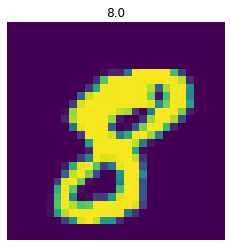

In [ ]:
# feature 와 label 분리
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train set과 test set의 분리.
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train) # numpy 배열을 Torch Tensor로 변환하기.
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain) # Dataset wrapping tensors. 즉, 학습데이터 X와 레이블 Y를 묶어 놓는 컨테이너 역할
test = TensorDataset(featuresTest,targetsTest)

# data loader
## 순서로 섞어서 batch_size 개수씩 데이터를 변환하는 DataLoader 작성
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

### RNN 모델 class 생성

In [ ]:
##RNNMOdel은 nn.Module을 상속받는다. 
##super().__init__은 부모 클래스의 init을 상속받는 것이다. 
class RNNModel(nn.Module):
  #구조를 쌓기 위한 변수 선언.
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions(Hidden의 차원 수)
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers(Hidden layer의 개수)
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer (fully-connected-layer)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    #feedforward를 위한 각 구조 연결.
    def forward(self, x):
        
        # Initialize hidden state with zeros, layer_dim은 Hidden layer의 개수.즉, cell의 개수.
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)) #x.size는 전체 원소의 개수 반환
        
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# Create RNN
input_dim = 28    # input dimension 
hidden_dim = 100  # hidden layer dimension #Hidden layer에 포함된 유닛의 개수 
layer_dim = 1     # number of hidden layers #Hidden layer의 개수 
output_dim = 10   # output dimension, 출력 값이 10개로 나온다는 뜻. 

#모델 구축
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
len(train.tensors[0][1]) / 28

NameError: ignored

### 학습하기

In [ ]:
seq_dim = 28  #sequence의 길이 784 = 28(input_dimension) * 28 (sequence_dimension)
#필요한 list 정의
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs): #epoch는 전체 데이터를 한 번 보는 것.
    for i, (images, labels) in enumerate(train_loader): #i는 데이터의 순서, image는 feature들

        #train_loader에는 batch_size 만큼의 데이터가 한 단위로 들어가 있다. 
        train  = Variable(images.view(-1,  seq_dim, input_dim)) #tensor의 크기(size)나 모양을 변경하고 싶을 때 torch.view사용. numpy의 reshape 같은 역할. 앞의 -1은 batch_size 단위로 학습시키기 위해 붙여주는 듯.
        labels = Variable(labels)
        
        # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인)
        # 갱신할 변수들에 대한 모든 변화도를 0으로 만듭니다. 이렇게 하는 이유는
        # 기본적으로 .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고)
        # 누적되기 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를
        # 참조하세요.
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients, 역전파 단계
        loss.backward()
        
        # Update parameters , 파라미터 update
        optimizer.step()
        
        count += 1
        #250번마다 출력.
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value , max인 값 하나 출력.
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8662906885147095  Accuracy: 25.904762268066406 %
Iteration: 1000  Loss: 1.2908999919891357  Accuracy: 57.66666793823242 %
Iteration: 1500  Loss: 0.5768565535545349  Accuracy: 82.27381134033203 %
Iteration: 2000  Loss: 0.5902754068374634  Accuracy: 84.75 %
Iteration: 2500  Loss: 0.236233189702034  Accuracy: 89.85713958740234 %
Iteration: 3000  Loss: 0.10372806340456009  Accuracy: 92.71428680419922 %
Iteration: 3500  Loss: 0.3212709128856659  Accuracy: 90.32142639160156 %
Iteration: 4000  Loss: 0.09733286499977112  Accuracy: 94.39286041259766 %
Iteration: 4500  Loss: 0.5112283825874329  Accuracy: 84.89286041259766 %
Iteration: 5000  Loss: 0.09765458852052689  Accuracy: 94.8452377319336 %
Iteration: 5500  Loss: 0.22413517534732819  Accuracy: 95.03571319580078 %
Iteration: 6000  Loss: 0.23084676265716553  Accuracy: 95.69047546386719 %
Iteration: 6500  Loss: 0.1013358011841774  Accuracy: 95.80952453613281 %
Iteration: 7000  Loss: 0.15087687969207764  Accuracy: 96.107

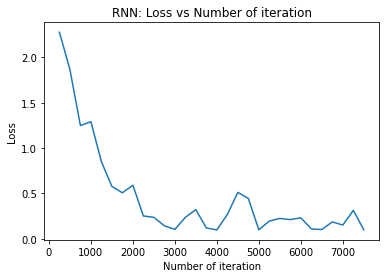

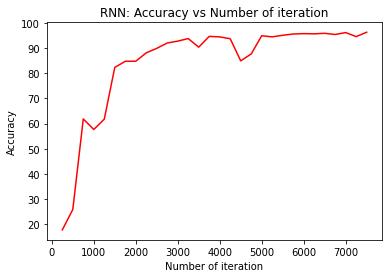

In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

In [ ]:
labels.size()

torch.Size([100])

In [ ]:
iteration_list

[]